In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os, glob
import cv2
import pandas as pd
import sys
import time, datetime
import torch
from torch import nn
from torch.nn import functional as F

%matplotlib inline

# 1. Load model

In [2]:
class CNN_v1(nn.Module):
    def __init__(self, n_ch, n_cls):
        super().__init__()

        self.conv1_1 = nn.Conv2d(n_ch, 16, 3, 1, padding=1)
        self.conv1_2 = nn.Conv2d(16, 16, 3, 1, padding=1)
        self.maxp1 = nn.MaxPool2d(2, 2)
        
        self.conv2_1 = nn.Conv2d(16, 16, 3, 1, padding=1)
        self.conv2_2 = nn.Conv2d(16, 16, 3, 1, padding=1)
        self.maxp2 = nn.MaxPool2d(2, 2)
        
        self.conv3_1 = nn.Conv2d(16, 16, 3, 1, padding=1)
        self.conv3_2 = nn.Conv2d(16, 16, 3, 1, padding=1)
        self.maxp3 = nn.MaxPool2d(2, 2)
        
        self.conv4_1 = nn.Conv2d(16, 32, 3, 1, padding=1)
        self.conv4_2 = nn.Conv2d(32, 32, 3, 1, padding=1)
        self.maxp4 = nn.MaxPool2d(2, 2)

        self.conv5_1 = nn.Conv2d(32, 32, 3, 1, padding=1)
        self.conv5_2 = nn.Conv2d(32, 32, 3, 1, padding=1)
        self.maxp5 = nn.MaxPool2d(2, 2)
        
        self.conv6_1 = nn.Conv2d(32, 32, 3, 1, padding=1)
        self.conv6_2 = nn.Conv2d(32, 32, 3, 1, padding=1)
        self.maxp6 = nn.MaxPool2d(2, 2)
        
        self.conv7_1 = nn.Conv2d(32, 64, 3, 1, padding=1)
        self.conv7_2 = nn.Conv2d(64, 64, 3, 1, padding=1)
        self.maxp7 = nn.MaxPool2d(2, 2)
        
        self.dense1 = nn.Linear(4*4*64, 100)
        self.dropout1 = nn.Dropout(0.3)
        self.dense2 = nn.Linear(100, 50)
        self.dropout2 = nn.Dropout(0.3)
        self.dense3 = nn.Linear(50, n_cls)
        
    def forward(self, x):
        x = F.relu(self.conv1_1(x))
        x = F.relu(self.conv1_2(x))
        x = self.maxp1(x)
        x = F.relu(self.conv2_1(x))
        x = F.relu(self.conv2_2(x))
        x = self.maxp2(x)
        x = F.relu(self.conv3_1(x))
        x = F.relu(self.conv3_2(x))
        x = self.maxp3(x)
        x = F.relu(self.conv4_1(x))
        x = F.relu(self.conv4_2(x))
        x = self.maxp4(x)
        x = F.relu(self.conv5_1(x))
        x = F.relu(self.conv5_2(x))
        x = self.maxp5(x)
        x = F.relu(self.conv6_1(x))
        x = F.relu(self.conv6_2(x))
        x = self.maxp6(x)
        x = F.relu(self.conv7_1(x))
        x = F.relu(self.conv7_2(x))
        x = self.maxp7(x)
        # flatten
        x = x.view(-1, 4*4*64)
        feature = F.relu(self.dense1(x))
        x = self.dropout1(feature)
        x = F.relu(self.dense2(x))
        x = self.dropout2(x)
        x = self.dense3(x)
        x = F.softmax(x, dim = -1)
        return x

모델 불러놓고 inference할 수 있도록 class 함수로 정리해놓음.. 이걸 다 풀어서 하면 너무 복잡하기 때문에 

In [3]:
def find_models(model_dir, model_name):
    model_list = [i for i in sorted(os.listdir(model_dir)) if model_name in i]
#     model_list = sorted(glob.glob('nh/model/{}*'.format(model_name)))
    return model_list

def batch_idxs(dataset, batch_size = 32, shuffle = False):

    idxs = np.arange(len(dataset))
    total_size = len(idxs)
    if shuffle:
        np.random.shuffle(idxs)
    start = 0
    b_idxs = []
    while True:
        if total_size > start + batch_size: 
            b_idxs.append(list(idxs[start:start+batch_size]))  
            start += batch_size
        elif total_size <= start + batch_size: 
            b_idxs.append(list(idxs[start:]))
            break 
    return b_idxs

class cnn_model:
    def __init__(self, network = 'CNN_v1', n_ch = 3, n_cls = 2, 
                 model_dir = 'model/', model_name = 'binary', gpu_idx = 3):
        
        self.network, self.n_ch, self.n_cls, = network, n_ch, n_cls
        self.model_dir, self.model_name = model_dir, model_name
        self.gpu_idx = gpu_idx
        
        self.model_list = find_models(self.model_dir, self.model_name)
        self.get_device(self.gpu_idx)
        
        print('model:')
        for model in self.model_list:
            print(model)
            
        if len(self.model_list) == 1:
            print()
            self.import_model(self.n_ch, self.n_cls, self.model_dir, self.model_list[0])
        else:
            print('The last model is selected\n')
            self.import_model(self.n_ch, self.n_cls, self.model_dir, self.model_list[-1])
        
    def get_device(self, gpu_idx = 3):
#         self.device = torch.device("cuda:{}".format(GPU_idx) if torch.cuda.is_available() else "cpu")
        if torch.cuda.is_available() and type(gpu_idx) == int:
            self.device = torch.device("cuda:{}".format(gpu_idx))
            current_device = torch.cuda.current_device()
#             print("Device:", torch.cuda.get_device_name(current_device), '\n')
        else:
            self.device = torch.device('cpu')
            print("Device: CPU\n")
            
    def import_model(self, n_ch, n_cls, model_dir, model_file):
        
        if self.network == 'CNN_v1':
#             from ce_model.cnns import CNN_v1
            network = CNN_v1(n_ch, n_cls)
        
        self.model = network
        self.model = self.model.to(self.device)
#         self.model.load_state_dict(torch.load(model_dir + model_file))
        self.model.load_state_dict(torch.load(model_dir + model_file, 
                                              map_location=lambda storage, loc: storage.cuda(self.gpu_idx)))
        self.model.eval()

    def prediction(self, x):
#         test_X, test_Y = torch.tensor(test_X, device=self.device).float(), torch.tensor(test_Y, device=self.device).long()
        prob = self.model(torch.tensor(x, device=self.device).float())
        _, pred = torch.max(prob, 1)
        
#         return torch.tensor(output, device = 'cpu').numpy(), pred.tolist()
        return prob.cpu().detach().numpy(), pred.tolist()

    def inference(self, x, batch_size):
        
        start_time = time.time()
        batches = batch_idxs(x, batch_size = batch_size)
        self.score, self.pred = [], []
        for i, batch in enumerate(batches):   
#             score, pred = self.Model_pred(self.model, test_X[batch, :, :, :], test_Y[batch])
            score, pred = self.prediction(x[batch, :, :, :])
            self.score.append(score), self.pred.append(pred)
            progress_bar(i+1, len(batches), prefix = '{}: {}(*{})'.format(len(x), len(batches), batch_size), 
                          suffix = 'prediction', barLength = 50)
        self.score, self.pred = np.concatenate(self.score), np.concatenate(self.pred)
        
        pred_time = time.time() - start_time
        self.pred_time = sec_to_m_s_ms(pred_time)

    def evaluation(self, x, y, batch_size, print_accr = True):
        
        if len(self.model_list) != 1:
            for i, model in enumerate(self.model_list):
                self.import_model(self.n_ch, self.n_cls, self.model_dir, model)
                self.inference(x, batch_size)
                self.accr = compute_accr(y, self.pred, print_show = print_accr)
                
        elif len(self.model_list) == 1:
            self.inference(x, batch_size)
            self.accr = compute_accr(y, self.pred, print_show = print_accr)

    def extract_gradcam(self, img, target_layers = ['conv6_2'], target_class = None):
        
        x = torch.tensor(img, device=self.device).float()
        img_shape = img.shape[2:]
        (dark_xs, dark_ys) = np.where(np.mean(img[0], axis = 0) < 6)
        
#         img = np.transpose(img, (0, 2, 3, 1))
        
        grad_by_layer = []
        def save_gradient(grad):
            grad_by_layer.append(grad)

        feature_by_layer = []

        for name, module in self.model._modules.items():
        #         print(name)
            x = module(x)
            if 'conv' in name:
                x = nn.ReLU()(x)
            if name in target_layers:
                feature_by_layer.append(x) 
                x.register_hook(save_gradient)
            if 'maxp7' == name:
                x = x.view(x.size(0), -1)
        
        logits = x
#         logits = F.softmax(x, -1)
        
        one_hot = np.zeros((img.shape[0], 2), dtype=np.float32)
        one_hot = torch.from_numpy(one_hot).to(self.device).requires_grad_(True)
        
        if target_class == None:
            for i, cls in enumerate(logits.argmax(axis =1).tolist()):
                one_hot[i, cls] = 1
        elif target_class is not None:
            one_hot[:, target_class] = 1
#         one_hot = np.sum(logits * one_hot)

        for target_layer in target_layers:
            self.model._modules[target_layer].zero_grad()
        
        self.model.zero_grad()
        
        logits.backward(gradient=one_hot, retain_graph=True)
        
        cam_by_layer = []
        for features, gradients in zip(feature_by_layer, reversed(grad_by_layer)): 
            cams = []
            for n, feature, gradient in zip(range(len(img)), features, gradients):

                grad_val = gradient.data.cpu().numpy()
                weights = np.mean(grad_val, axis=(1, 2))

                target = feature.cpu().data.numpy()
                cam = np.zeros(target.shape[1:], dtype=np.float32)

                for i, w in enumerate(weights):
                    cam += w * target[i, :, :]
                
#                 cam = np.abs(cam)
                cam = np.maximum(cam, 0)
                cam_re = cv2.resize(cam, img.shape[2:], interpolation=cv2.INTER_CUBIC)
                cam_re = cam_re - np.min(cam_re)
                cam_re = cam_re / np.max(cam_re)
                cam_re[dark_xs, dark_ys] = 0

        #         cams.append(cam_re)

                heatmap = cv2.applyColorMap((cam_re*255).astype('uint8'), cv2.COLORMAP_JET)
                target_pic = np.transpose(img[n], (1, 2, 0))
                cam_on_img = (heatmap*0.3 + target_pic*0.7).astype('uint8')

                cams.append(cam_on_img)  
            cam_by_layer.append(cams)
            
        if len(feature_by_layer) == 1:
            return cams
        elif len(feature_by_layer) > 1:
            return cam_by_layer

In [4]:
model_dir = './model/'
model_name = 'np-hd_---_--'
gpu_idx = 3

model = cnn_model(network = 'CNN_v1', n_ch = 3, n_cls = 2, 
                  model_dir = model_dir, model_name = model_name, gpu_idx = gpu_idx)

model:
np-hd_---_--_0.0001_32_2101221757_042_t_accr_0.9350_t_loss_0.376242_v_accr_0.9366_v_loss_0.374310.pt



In [5]:
model.model

CNN_v1(
  (conv1_1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxp1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2_1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxp2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3_1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxp3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4_1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4_2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxp4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5_1): Conv

# 2. Model Inference and Clip Processing

- clip processing이란 모델의 예측값과 grad-cam을 바탕으로 기존 비디오에 비해 판독속도를 높일 수 있는 판독용 clip을 만드는 작업을 뜻함
- 양성으로 예측한 프레임(pred_idx)을 기준으로 앞 뒤 5프레임씩 추가해서 clip용 프레임을 만들게 되는데, 이는 판독시 영상을 smooth하게 보기 위함
- 사실 다른 관련논문들을 양성으로 예측한 프레임만 가지고 비교하는 임상평가 연구가 많은데, 새로운 clip을 만든다는 시도는 아직 없어보임 

frame들을 cropping(기본 전처리인 활자 제거 및 외곽 틀 제거)하여 불러오는 함수

In [6]:
def cropping(img):
    img = np.array(img, dtype = 'f4')
    img_pre = img[32:544, 32:544, :]
    for i in range(100):
        for j in range(100):
            if i + j > 99:
                pass
            else :
                img_pre[i, j, :] = 0
                img_pre[i, -j, :] = 0
    return img_pre.astype('uint8')

def load_frame(frame_path, img_ch = 'bgr'):
    frame = cv2.imread(frame_path)
    if img_ch == 'rgb':
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
#     frame_pre = pre_process(frame)
    frame_pre = cropping(frame)
    return frame_pre

def load_frames(frame_dir):
    #frame 디렉토리에 있는 이미지 파일 이름 가져와서 정렬
    frame_names = np.sort(os.listdir(frame_dir))
    n_frame = frame_names.shape[0]
    frames_pre = []
    
    #이미지 불러오는 시작 시간 
    start_time = time.time()
    for i, frame_name in enumerate(frame_names):
        # 프레임 불러와서 frames_pre 에 저장 
        frame = load_frame(os.path.join(frame_dir, frame_name))
        frames_pre.append(frame)
        progress_bar(i+1, n_frame, prefix = n_frame, suffix = 'loading frames', barLength = 80)
#     frames_pre = np.asarray(frames_pre)
    frames_pre = np.array(frames_pre)
    time_taken = time.time() - start_time
    time_taken = sec_to_m_s_ms(time_taken)
    # 리턴으로 불러온 프레임들과 걸린 시간 
    return frames_pre, time_taken

양성예측한 프레임을 기준으로 앞뒤로 5프레임씩 더한 프레임들의 idx를 찾아주는 함수

In [7]:
def find_clip_idxs(pred_idx, n_frame):
    assert len(pred_idx) > 0, 'model must predict a image as positive at least'
    clip_idx = []
    for p_idx in pred_idx:
        clip_idx += [p_idx + i - 5 for i in range(11) if (p_idx + i-5) < n_frame and (p_idx + i-5) >= 0]
    return np.asarray(sorted(set(clip_idx)))

모델이 예측하고 프레임마다 양성클래스에 대한 grad-cam을 얻어내는 함수들

In [8]:
def Image_norm(img, mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]):
    """
    img: np.array (h, w, ch) or (n, h, w, ch) ~ [0, 255] integer
    mean and std vaules were used for normalizing input data to ImageNet models in torch 
    """
    return (img/255-mean)/std

def reshape4torch(img, norm = False):
    """
    (sample #, height, width, channel) -> (sample #, channel, height, width)
    """
    if norm == True:
        img = Image_norm(img)
        
    if len(img.shape) == 4:
        img = np.transpose(img, (0, 3, 1, 2))
        return img
    elif len(img.shape) == 3:
        img = np.transpose(img, (2, 0, 1))
        return np.expand_dims(img, axis=0)

def model_pred(model, frames_pre):
    model.inference(reshape4torch(frames_pre), batch_size = 16)
    probs = model.score
    pred_time = model.pred_time
    return probs, pred_time

def get_gradcam(model, frames_pre, clip_idx, batch_size, target_layers = ['conv6_2'], target_class = 0):
    start_time = time.time()
    batches = batch_idxs(clip_idx, batch_size)
    cams = []
    
    for i, batch in enumerate(batches):
        cam_on_img = model.extract_gradcam(reshape4torch(frames_pre[clip_idx[batch]]), target_layers, target_class)
        cams.append(cam_on_img)
        
        progress_bar(i+1, len(batches), barLength = 80,
                      prefix = '{}: {}(*{})'.format(len(clip_idx), len(batches), batch_size), 
                      suffix = 'get gradcam in clip frame')
       
    cams = np.concatenate(cams)

    cam_time = time.time() - start_time
    cam_time = sec_to_m_s_ms(cam_time)
    
    return cams, cam_time

얻어진 양성예측 값들과 grad-cam을 바탕으로 clip frame을 만들고 저장하는 함수들

'ensemble'은 이전에 저널에 게재한 논문의 방법론으로 negative와 hemorrhagic을 분류하는 모델과 negative와 ulcerative(depressed)를 분류하는 모델, 둘에 대해 inference시켜 클래스 예측은 두 모델의 양성예측확률 중 가장 큰 값으로 하고, 두 양성예측확률을 모두 return하던 방식인데, 이는 sensitivity를 강화시키지만, false positive가 많아진다는 점으로 <font color = 'red'>현재는 사용하지 않음</font>

'ensemble'기법의 code는 tensorflow_1.14.0(old)폴더에 있는데, pytorch로 넘어오면서 자연스레 사용하지 않게 되어서 여기선 code를 구현해놓지 않았음.

In [9]:
def merging(image, cam):
    cam_pad = np.zeros([576, 576, 3]) # zero padding
#     cam = cv2.cvtColor(cam, cv2.COLOR_RGB2BGR)
    cam_pad[32:544,32:544, :] = cam
    return np.concatenate([image, cam_pad], axis = 1)

def captioning(image, softmax, model_type = 'binary'):
    if model_type == 'binary':
        cap = "Predict : {}".format(np.argmax(softmax, axis =0))
        cv2.putText(image, cap, (230, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
        cap2 = 'Probability: {0:0.2f}%'.format(100*softmax[1])
        cv2.putText(image, cap2, (760, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
    elif model_type == 'ensemble':
        cap = "Predict : {}".format(np.argmax(softmax[:2], axis =0))
        cv2.putText(image, cap, (230, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
        cap2 = 'Hem.: {0:0.2f}%, Ulc.: {1:0.2f}%'.format(100*softmax[3], 100*softmax[5])
        cv2.putText(image, cap2, (700, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
        
def process_and_save(frame_dir, save_dir, frames_pre, cams, preds, clip_idx, model_type = 'binary'):
    
    frame_names = np.sort(os.listdir(frame_dir))
    
    if not(os.path.isdir(save_dir)):
        os.makedirs(save_dir)
        os.makedirs(save_dir + '/clip_frame')
        os.makedirs(save_dir + '/pred_frame')
    
    start_time = time.time()
    for i, idx in enumerate(clip_idx):
        image = cv2.imread(os.path.join(frame_dir, frame_names[idx]))
        
        if preds[idx, 1] >= 0.2:
            merged = merging(image, cams[i])
            captioning(merged, preds[idx], model_type)
        elif preds[idx, 1] < 0.2:
            merged = merging(image, frames_pre[idx])
            captioning(merged, preds[idx], model_type)

        cv2.imwrite(save_dir + '/clip_frame/' + frame_names[idx], merged)
        if model_type == 'binary':
            if np.argmax(preds[idx]) == 1:
                cv2.imwrite(save_dir + '/pred_frame/' + frame_names[idx], merged)
#         elif model_type == 'ensemble':
#             if np.argmax(preds[idx][:2]) == 1:
#                 cv2.imwrite(save_dir + 'pred_frame/' + frame_names[idx], merged)
        progress_bar(i+1, len(clip_idx), prefix = len(clip_idx), suffix = 'process and save --> {}'.format(save_dir), 
                      barLength = 80)
    time_taken = time.time() - start_time
    time_taken = sec_to_m_s_ms(time_taken)
    return time_taken

작업의 경과 및 걸린 시간을 계산하기 위한 함수들

In [10]:
def progress_bar(iteration, total, prefix = '', suffix = '', decimals = 1, barLength = 100):
    formatStr = "{0:." + str(decimals) + "f}"
    percent = formatStr.format(100 * (iteration / float(total)))
    filledLength = int(round(barLength * iteration / float(total)))
    bar = '#' * filledLength + '-' * (barLength - filledLength)
    sys.stdout.write('\r{} |{} | {}{} {}'.format(prefix, bar, percent, '%', suffix)),
    if iteration == total:
        sys.stdout.write('\n')
    sys.stdout.flush()

def sec_to_m_s_ms(sec):
    """
    sec: time.time() - start_time
    output: ex) 00:47.421
    """
    min_sec = time.strftime("%M:%S", time.gmtime(sec))
    ms = '{:03d}'.format(int((sec - int(sec))*1000))   
    return '.'.join([min_sec, ms])

def values_from_str_time(str_time):
    """
    str_time: ex) 00:47.421
    """
    str_time.split('.')[0].split(':')

    sec = 60*int(str_time.split('.')[0].split(':')[0]) + int(str_time.split('.')[0].split(':')[1])
    msec = int(str_time.split('.')[1])

    return sec, msec

def total_sum_time(times):
    sec = 0
    msec = 0
    for time in times:
        sec1, msec1 = values_from_str_time(time)
        sec += sec1
        msec += msec1
        
    m, s = sec//60, sec%60
    s_, ms = msec//1000, msec%1000

    if (s+s_) >= 60:
        m_, s = (s+s_)//60, (s+s_)%60 
        m = m + m_
        
    elif (s+s_)<60:
        s = s + s_
    
    total_time = '{:02d}:{:02d}.{:03d}'.format(m, s, ms)
    return total_time

readme.txt를 불러와서 그에 따라 똑같이 숫자폴더가 생성되고, 그 아래에 결과들이 저장되게 됨

In [11]:
frame_root = './video_sample'

# readme.txt 읽어옴
video_log = pd.read_csv(frame_root + '/readme.txt', header = 0, delimiter = '|', encoding = "utf-8")

video_log

,index,video,elapsed time,number of frames
0,1,김 민경 (19998616) 31 Aug 18_1.mpg,01:16.963,7991
1,2,박 명자 (28372171) 10 Dec 18_1.mpg,02:28.793,15355


비디오마다 모든 작업에 걸린 시간 및 프레임수, 양성예측된 프레임수, 클립을 만들기 위한 프레임수 등을 기록함

In [12]:
# 최종 처리 이후 csv 파일에 들어갈 column 이름들 (for statistical analysis)
record = pd.DataFrame(columns = ['index', 'video', '# of frames', 'video length', 'save frame time', 'load frame time', 
                                 'pred. time', '# of positive frames', '# of clip frames', 'clip length',
                                 'Grad-CAM time','process and save time', 'total time'])

In [13]:
print('model inference, processing, and saving')

fps = 5
save_root = './video_analysis/{}'.format(model_name)

for i in range(len(video_log)):
    video_info = video_log.iloc[i]

    idx, video_name, frame_save_time, n_frame = (video_info['index'], 
                                                 video_info['video'], 
                                                 video_info['elapsed time'], 
                                                 video_info['number of frames'])

    print('')
    print(idx, ':', video_name, n_frame, '\n')

    frame_dir = os.path.join(frame_root, '{:02d}'.format(idx))

    # 프레임을 numpy 형태로 불러옴 & 걸린 시간도 가져옴
    frames_pre, frame_load_time = load_frames(frame_dir)

    # Binary Model과 이미지 파일을 model_pred_and_time 함수에 넣고 리턴으로 binary model의 예측 결과와 걸린 시간을 가져옴
    # 예측결과는 model의 softmax 결과 값이 담긴 list
    preds, pred_time = model_pred(model, frames_pre)

    # 각각의 예측 모델이 예측한 frame은 softmax의 argmax 결과가 1인 index에 해당하는 frame
    # prediction에 해당하는 index만 가져옴 
    pred_idx = np.where(np.argmax(preds, axis = 1) == 1)[0]
    # prediction index 전후 5프레임씩 더하여, 비디오 클립에 필요한 index를 가져옴
    clip_idx = find_clip_idxs(pred_idx, len(frames_pre))

    # 모델과, 프레임 그리고 grad-cam이 필요한 프레임의 index를 통해 grad cam image를 구함
    cams, cam_time = get_gradcam(model, frames_pre, clip_idx, batch_size = 64, target_layers = ['conv7_2'], target_class = None)


    save_dir = os.path.join(save_root, '{:02d}'.format(idx))
    # 원본 frame과 grad-cam frame를 붙여서 아래 위치에 저장함
    processing_time = process_and_save(frame_dir, save_dir, frames_pre, cams, preds, clip_idx)

    total_time = total_sum_time([frame_save_time, frame_load_time, pred_time, cam_time, processing_time])

    # 파일 저장 과정에서 단계별로  소요된 시간 계산
    record.loc[i] = [idx, video_name, n_frame, sec_to_m_s_ms(n_frame/fps), frame_save_time, frame_load_time, 
                     pred_time, len(pred_idx), len(clip_idx), sec_to_m_s_ms(len(clip_idx)/fps),
                     cam_time, processing_time, total_time]


record.to_csv(save_root + '/record.csv',encoding='utf-8-sig', index = False)

model inference, processing, and saving

1 : 김 민경 (19998616) 31 Aug 18_1.mpg 7991 

7991 |################################################################################ | 100.0% loading frames
7991: 500(*16) |################################################## | 100.0% prediction
573: 9(*64) |################################################################################ | 100.0% get gradcam in clip frame
573 |################################################################################ | 100.0% process and save --> ./video_analysis/np-hd_---_--/01

2 : 박 명자 (28372171) 10 Dec 18_1.mpg 15355 

15355 |################################################################################ | 100.0% loading frames
15355: 960(*16) |################################################## | 100.0% prediction
1669: 27(*64) |################################################################################ | 100.0% get gradcam in clip frame
1669 |##########################################################

In [14]:
record

,index,video,# of frames,video length,save frame time,load frame time,pred. time,# of positive frames,# of clip frames,clip length,Grad-CAM time,process and save time,total time
0,1,김 민경 (19998616) 31 Aug 18_1.mpg,7991,26:38.200,01:16.963,01:34.877,00:11.034,116,573,01:54.599,00:07.288,00:12.257,03:22.419
1,2,박 명자 (28372171) 10 Dec 18_1.mpg,15355,51:11.000,02:28.793,03:05.760,00:21.914,325,1669,05:33.800,00:21.071,00:35.556,06:53.094


저장된 폴더를 보면 양성으로 예측한 프레임들이 'pred_frame'에, 클립을 만들기 위해 저장된 프레임들이 'clip_frame'에 저장된다.

pred_frame은 검토용으로 사용될 수 있고, clip frame은 clip을 만들기 위한 frame이다. 

In [15]:
save_dir

'./video_analysis/np-hd_---_--/02'

In [16]:
os.listdir(save_dir)

['clip_frame', 'pred_frame']

In [17]:
os.listdir(save_dir + '/' + 'pred_frame/')

['박 명자 (28372171) 10 Dec 18_1_frame_00027.jpg',
 '박 명자 (28372171) 10 Dec 18_1_frame_00322.jpg',
 '박 명자 (28372171) 10 Dec 18_1_frame_00323.jpg',
 '박 명자 (28372171) 10 Dec 18_1_frame_01037.jpg',
 '박 명자 (28372171) 10 Dec 18_1_frame_01059.jpg',
 '박 명자 (28372171) 10 Dec 18_1_frame_01432.jpg',
 '박 명자 (28372171) 10 Dec 18_1_frame_01447.jpg',
 '박 명자 (28372171) 10 Dec 18_1_frame_01978.jpg',
 '박 명자 (28372171) 10 Dec 18_1_frame_02147.jpg',
 '박 명자 (28372171) 10 Dec 18_1_frame_02157.jpg',
 '박 명자 (28372171) 10 Dec 18_1_frame_02158.jpg',
 '박 명자 (28372171) 10 Dec 18_1_frame_02208.jpg',
 '박 명자 (28372171) 10 Dec 18_1_frame_02230.jpg',
 '박 명자 (28372171) 10 Dec 18_1_frame_02232.jpg',
 '박 명자 (28372171) 10 Dec 18_1_frame_02354.jpg',
 '박 명자 (28372171) 10 Dec 18_1_frame_02395.jpg',
 '박 명자 (28372171) 10 Dec 18_1_frame_02497.jpg',
 '박 명자 (28372171) 10 Dec 18_1_frame_02691.jpg',
 '박 명자 (28372171) 10 Dec 18_1_frame_03251.jpg',
 '박 명자 (28372171) 10 Dec 18_1_frame_03252.jpg',
 '박 명자 (28372171) 10 Dec 18_1_frame_0389

결과물을 보면 환자정보가 있는 frame에 grad-cam이 씌워진 frame을 대칭으로 결합하고 predict 값과 양성예측 확률을 captioning하였음을 확인할 수 있다

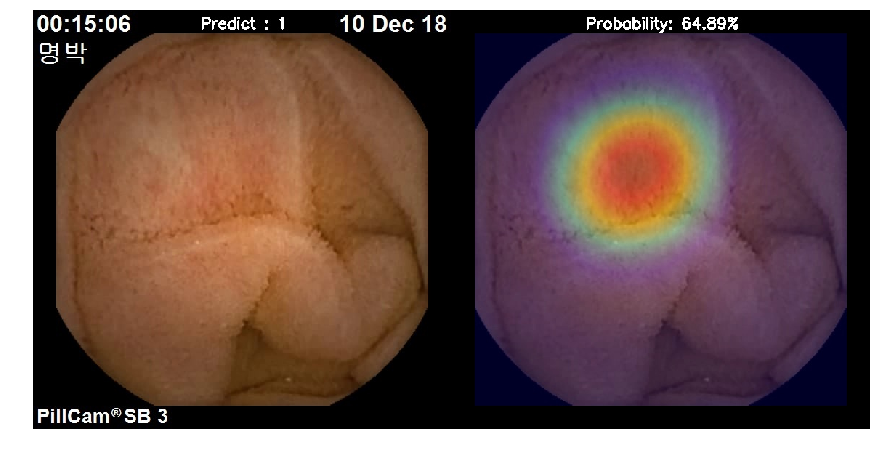

In [18]:
file = save_dir + '/' + 'pred_frame/' + os.listdir(save_dir + '/' + 'pred_frame/')[0]
output = cv2.imread(file)

import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(15, 10))
plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()